##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Probabilistic Programming in Oryx


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/oryx/examples/probabilistic_programming"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/spinoffs/oryx/examples/notebooks/probabilistic_programming.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/spinoffs/oryx/examples/notebooks/probabilistic_programming.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/spinoffs/oryx/examples/notebooks/probabilistic_programming.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [2]:
!pip install -q -U jax jaxlib
!pip install -q -Uq oryx -I
!pip install -q tfp-nightly --upgrade

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.1 requires gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
tensorflow 2.3.1 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
tensorflow-metadata 0.25.0 requires absl-py<0.11,>=0.9, but you'll have absl-py 0.11.0 which is incompatible.


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

oryx 0.1.3 requires tfp-nightly==0.12.0.dev20201107, but you'll have tfp-nightly 0.12.0.dev20201110 which is incompatible.


In [3]:
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax import random

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import oryx

Probabilistic programming is the idea that we can express probabilistic models using features from a programming language. Tasks like Bayesian inference or marginalization are then provided as language features and can potentially be automated.

Oryx provides a probabilistic programming system in which probabilistic programs are just expressed as Python functions; these programs are then transformed via composable function transformations like those in JAX! The idea is to start with simple programs (like sampling from a random normal) and compose them together to form models (like a Bayesian neural network). An important point of Oryx's PPL design is to enable programs to look like functions you'd already write and use in JAX, but are *annotated* to make transformations aware of them.

Let's first import Oryx's core PPL functionality.

In [4]:
from oryx.core.ppl import random_variable
from oryx.core.ppl import log_prob
from oryx.core.ppl import joint_sample
from oryx.core.ppl import joint_log_prob
from oryx.core.ppl import block
from oryx.core.ppl import intervene
from oryx.core.ppl import conditional
from oryx.core.ppl import graph_replace
from oryx.core.ppl import nest

## What are probabilistic programs in Oryx?

In Oryx, probabilistic programs are just pure Python functions that operate on JAX values and pseudorandom keys and return a random sample. By design, they are compatible with transformations like `jit` and `vmap`. However, the Oryx probabilistic programming system provides tools that enable you to *annotate* your functions in useful ways.

Following the JAX philosophy of pure functions, an Oryx probabilistic program is a Python function that takes a JAX `PRNGKey` as its first argument and any number of subsequent conditioning arguments. The output of the function is called a "sample" and the same restrictions that apply to `jit`-ed and `vmap`-ed functions apply to probabilistic programs (e.g. no data-dependent control flow, no side effects, etc.). This differs from many imperative probabilistic programming systems in which a 'sample' is the entire execution trace, including values internal to the program's execution. We will see later how Oryx can access internal values using the `joint_sample`, discussed below.

```
Program :: PRNGKey -> ... -> Sample
```
Here is a "hello world" program that samples from a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

0.8139614


/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


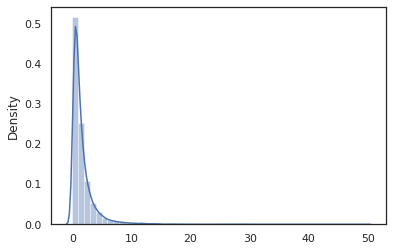

In [5]:
def log_normal(key):
  return jnp.exp(random_variable(tfd.Normal(0., 1.))(key))
  
print(log_normal(random.PRNGKey(0)))
sns.distplot(jit(vmap(log_normal))(random.split(random.PRNGKey(0), 10000)))
plt.show()

The `log_normal` function is a thin wrapper around a [Tensorflow Probability (TFP)](https://www.tensorflow.org/probability) distribution, but instead of calling `tfd.Normal(0., 1.).sample`, we've used `random_variable` instead. As we'll see later, `random_variable` enables us to convert objects into probabilistic programs, along with other useful functionality.

We can convert `log_normal` into a log-density function using the `log_prob` transformation: 

-0.9189385


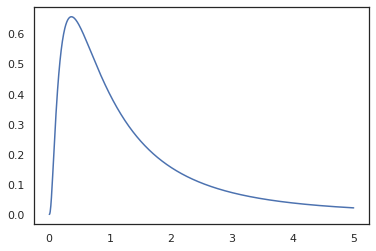

In [6]:
print(log_prob(log_normal)(1.))
x = jnp.linspace(0., 5., 1000)
plt.plot(x, jnp.exp(vmap(log_prob(log_normal))(x)))
plt.show()

Because we've annotated the function with `random_variable`, `log_prob` is aware that there was a call to `tfd.Normal(0., 1.).sample` and uses `tfd.Normal(0., 1.).log_prob` to compute the base distribution log prob. To handle the `jnp.exp`, `ppl.log_prob` automatically computes densities through bijective functions, keeping track of volume changes in the change-of-variable computation.

In Oryx, we can take programs and transform them using function transformations -- for example, `jax.jit` or `log_prob`. Oryx can't do this with just any program though; it requires sampling functions that have registered their log density function with Oryx.
Fortunately, Oryx automatically registers [TensorFlow Probability](https://www.tensorflow.org/probability) (TFP) distributions in its system.

## Oryx's probabilistic programming tools

Oryx has several function transformations geared towards probabilistic programming. We'll go over most of them and provide some examples. At the end, we'll put it all together into an MCMC case study. You can also refer to the documentation for `core.ppl.transformations` for more details.

### `random_variable`

`random_variable` has two main pieces of functionality, both focused on annotating Python functions with information that can be used in transformations.

1. `random_variable`' operates as the identity function by default, but can use type-specific registrations to convert objects into probabilistic programs.`

  For callable types (Python functions, lambdas, `functools.partial`s, etc.) and arbitrary `object`s (like JAX `DeviceArray`s) it will just return its input.

  ```python
  random_variable(x: object) == x
  random_variable(f: Callable[...]) == f
  ```
  Oryx automatically registers [TensorFlow Probability (TFP)](https://www.tensorflow.org/probability) distributions, which are converted into probabilistic programs that call the distribution's `sample` method.
  
  ```python
  random_variable(tfd.Normal(0., 1.))(random.PRNGKey(0)) # ==> -0.20584235
  ```
  Oryx additionally embeds information about the TFP distribution into JAX traces that enables automatically computing log densities.
2. `random_variable` can *tag* values with names, making them useful for downstream transformations, by providing an optional `name` keyword argument to `random_variable`. When we pass an array into `random_variable` along with a `name` (e.g. `random_variable(x, name='x')`), it just tags the value and returns it. If we pass in a callable or TFP distribution, `random_variable` returns a program that tags its output sample with `name`.

These annotations do not change the *semantics* of the program when executed, but only when transformed (i.e. the program will return the same value with or without the use of `random_variable`). 

Let's go over an example where we use both pieces of functionality together. 

In [7]:
def latent_normal(key):
  z_key, x_key = random.split(key)
  z = random_variable(tfd.Normal(0., 1.), name='z')(z_key)
  return random_variable(tfd.Normal(z, 1e-1), name='x')(x_key)

In this program we've tagged the intermediates `z` and `x`, which makes the transformations `joint_sample`, `intervene`, `conditional` and `graph_replace` aware of the names `'z'` and `'x'`. We'll go over exactly how each transformation uses names later.

### `log_prob`

The `log_prob` function transformation converts an Oryx probabilistic program into its log-density function. This log-density function takes a potential sample from the program as input and returns its log-density under the underlying sampling distribution.

```python
log_prob :: Program -> (Sample -> LogDensity)
```

Like `random_variable`, it works via a registry of types where TFP distributions are automatically registered, so `log_prob(tfd.Normal(0., 1.))` calls `tfd.Normal(0., 1.).log_prob`. For Python functions, however, `log_prob` traces the program using JAX and looks for sampling statements.
The `log_prob` transformation works on most programs that return random variables, directly or via invertible transformations but not on programs that sample values internally that aren't returned. If it cannot invert the necessary operations in the program, `log_prob` will throw an error.

Here are some examples of `log_prob` applied to various programs.

1. `log_prob` works on programs that directly sample from TFP distributions (or other registered types) and return their values.


In [8]:
def normal(key):
  return random_variable(tfd.Normal(0., 1.))(key)
print(log_prob(normal)(0.))

-0.9189385


2. `log_prob` is able to compute log-densities of samples from programs that transform random variates using bijective functions (e.g `jnp.exp`, `jnp.tanh`, `jnp.split`).


In [9]:
def log_normal(key):
  return 2 * jnp.exp(random_variable(tfd.Normal(0., 1.))(key))
print(log_prob(log_normal)(1.))

-1.159165


  In order to compute a sample from `log_normal`'s log-density, we first need to invert the `exp`, taking the `log` of the sample, and then add a volume-change correction using the inverse log-det Jacobian of `exp` (see the [change of variable](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function) formula from Wikipedia).

3. `log_prob` works with programs that output structures of samples like, Python dictionaries or tuples.

In [10]:
def normal_2d(key):
  x = random_variable(
    tfd.MultivariateNormalDiag(jnp.zeros(2), jnp.ones(2)))(key)
  x1, x2 = jnp.split(x, 2, 0)
  return dict(x1=x1, x2=x2)
sample = normal_2d(random.PRNGKey(0))
print(sample)
print(log_prob(normal_2d)(sample))

{'x1': DeviceArray([-0.7847661], dtype=float32), 'x2': DeviceArray([0.8564447], dtype=float32)}


-2.5125546


4. `log_prob` walks the traced computation graph of the function, computing both forward and inverse values (and their log-det Jacobians) when necessary in an attempt to connect returned values with their base sampled values via a well-defined change of variables. Take the following example program:

In [11]:
def complex_program(key):
  k1, k2 = random.split(key)
  z = random_variable(tfd.Normal(0., 1.))(k1)
  x = random_variable(tfd.Normal(jax.nn.relu(z), 1.))(k2)
  return jnp.exp(z), jax.nn.sigmoid(x)
sample = complex_program(random.PRNGKey(0))
print(sample)
print(log_prob(complex_program)(sample))

(DeviceArray(1.1547576, dtype=float32), DeviceArray(0.24830955, dtype=float32))
-1.0967848


In this program, we sample `x` conditionally on `z`, meaning we need the value of `z` before we can compute the log-density of `x`. However, in order to compute `z`, we first have to invert the `jnp.exp` applied to `z`. Thus, in order to compute the log-densities of `x` and `z`, `log_prob` needs to first invert the first output, and then pass it forward through the `jax.nn.relu` to compute the mean of `p(x | z)`.

Note: while `log_prob` will not work on programs that sample random variables that are not returned as outputs, `joint_sample` can convert a program into one that does.

For more information about `log_prob`, you can refer to `core.interpreters.log_prob`. In implementation, `log_prob` is closely based off of the `inverse` JAX transformation; to learn more about `inverse`, see `core.interpreters.inverse`.

### `joint_sample`

To define more complex and interesting programs, we'll use some latent random variables, i.e. random variables with unobserved values. Let's refer to the `latent_normal` program that samples a random value `z` that is used as the mean of another random value `x`.

In [12]:
def latent_normal(key):
  z_key, x_key = random.split(key)
  z = random_variable(tfd.Normal(0., 1.), name='z')(z_key)
  return random_variable(tfd.Normal(z, 1e-1), name='x')(x_key)

In this program, `z` is latent so if we were to just call `latent_normal(random.PRNGKey(0))` we would not know the actual value of `z` that is responsible for generating `x`.

`joint_sample` is a transformation that transforms a program into another program that returns a dictionary mapping string names (tags) to their values.
In order to work, we need to make sure we tag the latent variables to ensure they appear in the transformed function's output.

In [13]:
joint_sample(latent_normal)(random.PRNGKey(0))

{'x': DeviceArray(0.01873656, dtype=float32),
 'z': DeviceArray(0.14389044, dtype=float32)}

Note that `joint_sample` transforms a program into another program that samples the joint distribution over its latent values, so we can further transform it. For algorithms like MCMC and VI, it's common to compute the log probability of the joint distribution as part of the inference procedure. `log_prob(latent_normal)` doesn't work because it requires marginalizing out `z`, but we can use `log_prob(joint_sample(latent_normal))`.

In [14]:
print(log_prob(joint_sample(latent_normal))(dict(x=0., z=1.)))
print(log_prob(joint_sample(latent_normal))(dict(x=0., z=-10.)))

-50.03529
-5049.535


Because this is such a common pattern, Oryx also has a `joint_log_prob` transformation which is just the composition of `log_prob` and `joint_sample`.

In [15]:
print(joint_log_prob(latent_normal)(dict(x=0., z=1.)))
print(joint_log_prob(latent_normal)(dict(x=0., z=-10.)))

-50.03529
-5049.535


### `block`

The `block` transformation takes in a program and a sequence of names and returns a program that behaves identically except that in downstream transformations (like `joint_sample`), the provided names are ignored.
An example of where `block` is handy is converting a joint distribution into a prior over the latent variables by "blocking" the values sampled in the likelihood.
For example, take `latent_normal`, which first draws a `z ~ N(0, 1)` then an `x | z ~ N(z, 1e-1)`. `block(latent_normal, names=['x'])` is a program that hides the `x` name, so if we do `joint_sample(block(latent_normal, names=['x']))`, we obtain a dictionary with just `z` in it. 

In [16]:
blocked = block(latent_normal, names=['x'])
joint_sample(blocked)(random.PRNGKey(0))

{'z': DeviceArray(0.14389044, dtype=float32)}

### `intervene`

The `intervene` transformation clobbers samples in a probabilistic program with values from the outside. Going back to our `latent_normal` program, let's say we were interested in running the same program but wanted `z` to be fixed to 4. Rather than writing a new program, we can use `intervene` to override the value of `z`.

/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


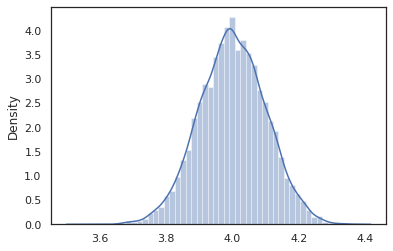

In [17]:
intervened = intervene(latent_normal, z=4.)
sns.distplot(vmap(intervened)(random.split(random.PRNGKey(0), 10000)))
plt.show();

The `intervened` function samples from `p(x | do(z = 4))` which is just a standard normal distribution centered at 4. When we `intervene` on a particular value, that value is *no longer considered a random variable*. This means that a `z` value will not be tagged while executing `intervened`.

### `conditional`

`conditional` transforms a program that samples latent values into one that conditions on those latent values. Returning to our `latent_normal` program, which samples `p(x)` with a latent `z`, we can convert it into a conditional program `p(x | z)`.

99.87485


49.874847


/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


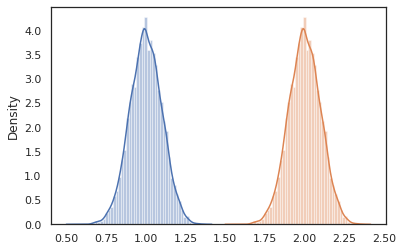

In [18]:
cond_program = conditional(latent_normal, 'z')
print(cond_program(random.PRNGKey(0), 100.))
print(cond_program(random.PRNGKey(0), 50.))
sns.distplot(vmap(lambda key: cond_program(key, 1.))(random.split(random.PRNGKey(0), 10000)))
sns.distplot(vmap(lambda key: cond_program(key, 2.))(random.split(random.PRNGKey(0), 10000)))
plt.show()

### `nest`

When we start composing probabilistic programs to build more complex ones, it's common to reuse functions that have some important logic. For example, if we'd like to build a Bayesian neural network, there might be an important `dense` program that samples weights and executes a forward pass.

If we reuse functions, however, we might end up with duplicate tagged values in the final program, which is disallowed by transformations like `joint_sample`. We can use the `nest` to create tag "scopes" where any samples inside of a named scope will be inserted into a nested dictionary.

In [19]:
def f(key):
  return random_variable(tfd.Normal(0., 1.), name='x')(key)

def g(key):
  k1, k2 = random.split(key)
  return nest(f, scope='x1')(k1) + nest(f, scope='x2')(k2)
joint_sample(g)(random.PRNGKey(0))

{'x1': {'x': DeviceArray(0.14389044, dtype=float32)},
 'x2': {'x': DeviceArray(-1.2515389, dtype=float32)}}

## Case study: Bayesian neural network

Let's try our hand at training a Bayesian neural network for classifying the classic [Fisher Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset. It's relatively small and low-dimensional so we can try directly sampling the posterior with MCMC.

First, let's import the dataset and some additional utilities from Oryx.

In [20]:
from sklearn import datasets
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

from oryx.experimental import mcmc
from oryx.util import summary, get_summaries

We begin by implementing a dense layer, which will have normal priors over the weights and bias. To do this, we first define a `dense` higher order function that takes in the desired output dimension and activation function. The `dense` function returns a probabilistic program that represents a conditional distribution `p(h | x)` where `h` is the output of a dense layer and `x` is its input. It first samples the weight and bias and then applies them to `x`.

In [21]:
def dense(dim_out, activation=jax.nn.relu):
  def forward(key, x):
    dim_in = x.shape[-1]
    w_key, b_key = random.split(key)
    w = random_variable(
          tfd.Sample(tfd.Normal(0., 1.), sample_shape=(dim_out, dim_in)),
          name='w')(w_key)
    b = random_variable(
          tfd.Sample(tfd.Normal(0., 1.), sample_shape=(dim_out,)),
          name='b')(b_key)
    return activation(jnp.dot(w, x) + b)
  return forward

To compose several `dense` layers together, we will implement an `mlp` (multilayer perceptron) higher order function which takes in a list of hidden sizes and a number of classes. It returns a program that repeatedly calls `dense` using the appropriate `hidden_size` and finally returns logits for each class in the final layer. Note the use of `nest` which creates name scopes for each layer.

In [22]:
def mlp(hidden_sizes, num_classes):
  num_hidden = len(hidden_sizes)
  def forward(key, x):
    keys = random.split(key, num_hidden + 1)
    for i, (subkey, hidden_size) in enumerate(zip(keys[:-1], hidden_sizes)):
      x = nest(dense(hidden_size), scope=f'layer_{i + 1}')(subkey, x)
    logits = nest(dense(num_classes, activation=lambda x: x),
                  scope=f'layer_{num_hidden + 1}')(keys[-1], x)
    return logits
  return forward

To implement the full model, we'll need to model the labels as categorical random variables. We'll define a `predict` function which takes in a dataset of `xs` (the features) which are then passed into an `mlp` using `vmap`. When we use `vmap(partial(mlp, mlp_key))`, we sample a single set of weights, but map the forward pass over all the input `xs`. This produces a set of `logits` which parameterizes independent categorical distributions.

In [23]:
def predict(mlp):
  def forward(key, xs):
    mlp_key, label_key = random.split(key)
    logits = vmap(partial(mlp, mlp_key))(xs)
    return random_variable(
        tfd.Independent(tfd.Categorical(logits=logits), 1), name='y')(label_key)
  return forward

That's the full model! Let's use MCMC to sample the posterior of the BNN weights given data; first we construct a BNN "template" using `mlp`.

In [24]:
bnn = mlp([200, 200], num_classes)

To construct a starting point for our Markov chain, we can use `joint_sample` with a dummy input.

In [25]:
weights = joint_sample(bnn)(random.PRNGKey(0), jnp.ones(num_features))
print(weights.keys())

dict_keys(['layer_1', 'layer_2', 'layer_3'])


Computing the joint distribution log probability is sufficient for many inference algorithms. Let's now say we observe `x` and want to sample the posterior `p(z | x)`. For complex distributions, we won't be able to marginalize out `x` (though for `latent_normal` we can) but we can compute an *unnormalized* log density `log p(z, x)` where `x` is fixed to a particular value. We can use the unnormalized log probability with MCMC to sample the posterior. Let's write this "pinned" log prob function.

In [26]:
def target_log_prob(weights):
  return joint_log_prob(predict(bnn))(dict(weights, y=labels), features)

Now we can use `tfp.mcmc` to sample the posterior using our unnormalized log density function. Note that we'll have to use a "flattened" version of our nested weights dictionary to be compatible with `tfp.mcmc`, so we use JAX's tree utilities to flatten and unflatten.

In [27]:
@jit
def run_chain(key, weights):
  flat_state, sample_tree = jax.tree_flatten(weights)

  def flat_log_prob(*states):
    return target_log_prob(jax.tree_unflatten(sample_tree, states))

  def trace_fn(_, results):
    return results.inner_results.accepted_results.target_log_prob

  flat_states, log_probs = tfp.mcmc.sample_chain(
    1000,
    num_burnin_steps=9000,
    kernel=tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(flat_log_prob, 1e-3, 100),
        9000, target_accept_prob=0.7),
    trace_fn=trace_fn,
    current_state=flat_state,
    seed=key)
  samples = jax.tree_unflatten(sample_tree, flat_states)
  return samples, log_probs
posterior_weights, log_probs = run_chain(random.PRNGKey(0), weights)

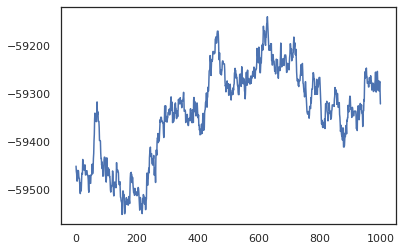

In [28]:
plt.plot(log_probs)
plt.show()

We can use our samples to take a Bayesian model averaging (BMA) estimate of the training accuracy. To compute it, we can use `intervene` with `bnn` to "inject" posterior weights in place of the ones that are sampled from the key. To compute logits for each data point for each posterior sample, we can double `vmap` over `posterior_weights` and `features`.

In [29]:
output_logits = vmap(lambda weights: vmap(lambda x: intervene(bnn, **weights)(
    random.PRNGKey(0), x))(features))(posterior_weights)
output_probs = jax.nn.softmax(output_logits)

In [30]:
print('Average sample accuracy:', (
    output_probs.argmax(axis=-1) == labels[None]).mean())
print('BMA accuracy:', (
    output_probs.mean(axis=0).argmax(axis=-1) == labels[None]).mean())

Average sample accuracy: 0.9874067


BMA accuracy: 0.99333334


## Conclusion

In Oryx, probabilistic programs are just JAX functions that take in (pseudo-)randomness as an input. Because of Oryx's tight integration with JAX's function transformation system, we can write and manipulate probabilistic programs like we're writing JAX code. This results in a simple but flexible system for building complex models and doing inference.